# Statistical Algos

## Notebook's Environment

In [11]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip install matplotlib==3.8.3
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0
  %pip installta==0.11.0
  %pip installyfinance==0.2.37

!python --version

Python 3.11.8


## Cloud Environment Setup

In [12]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

running localhost!


# Instruments

In [13]:
from constants import *

INTERVAL = YFinanceOptions.M15
TARGET_FUT=WHEAT_FUT.replace("=F", "")

TARGET_FUT, INTERVAL

('ZW', '15m')

## Data Load

In [14]:
import pandas as pd
import numpy as np

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)
print(futs_df.columns)
futs_df.head(2)

./data/\futures_15m.csv
(3936, 114)
Index(['CL_Open', 'CL_High', 'CL_Low', 'CL_Close', 'CL_Volume', 'CL_Spread',
       'DC_Open', 'DC_High', 'DC_Low', 'DC_Close',
       ...
       'ZS_Low', 'ZS_Close', 'ZS_Volume', 'ZS_Spread', 'ZW_Open', 'ZW_High',
       'ZW_Low', 'ZW_Close', 'ZW_Volume', 'ZW_Spread'],
      dtype='object', length=114)


,CL_Open,CL_High,CL_Low,CL_Close,CL_Volume,CL_Spread,DC_Open,DC_High,DC_Low,DC_Close,...,ZS_Low,ZS_Close,ZS_Volume,ZS_Spread,ZW_Open,ZW_High,ZW_Low,ZW_Close,ZW_Volume,ZW_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-20 22:16:00+00:00,81.07,81.129997,80.870003,81.019997,5918,0.259995,17.299999,18.040001,17.299999,18.040001,...,1208.75,1210.75,14397,7.25,548.5,551.75,546.75,549.5,4377,5.0
2024-03-20 22:31:00+00:00,81.07,81.129997,80.870003,81.019997,5918,0.259995,17.299999,18.040001,17.299999,18.040001,...,1208.75,1210.75,14397,7.25,548.5,551.75,546.75,549.5,4377,5.0


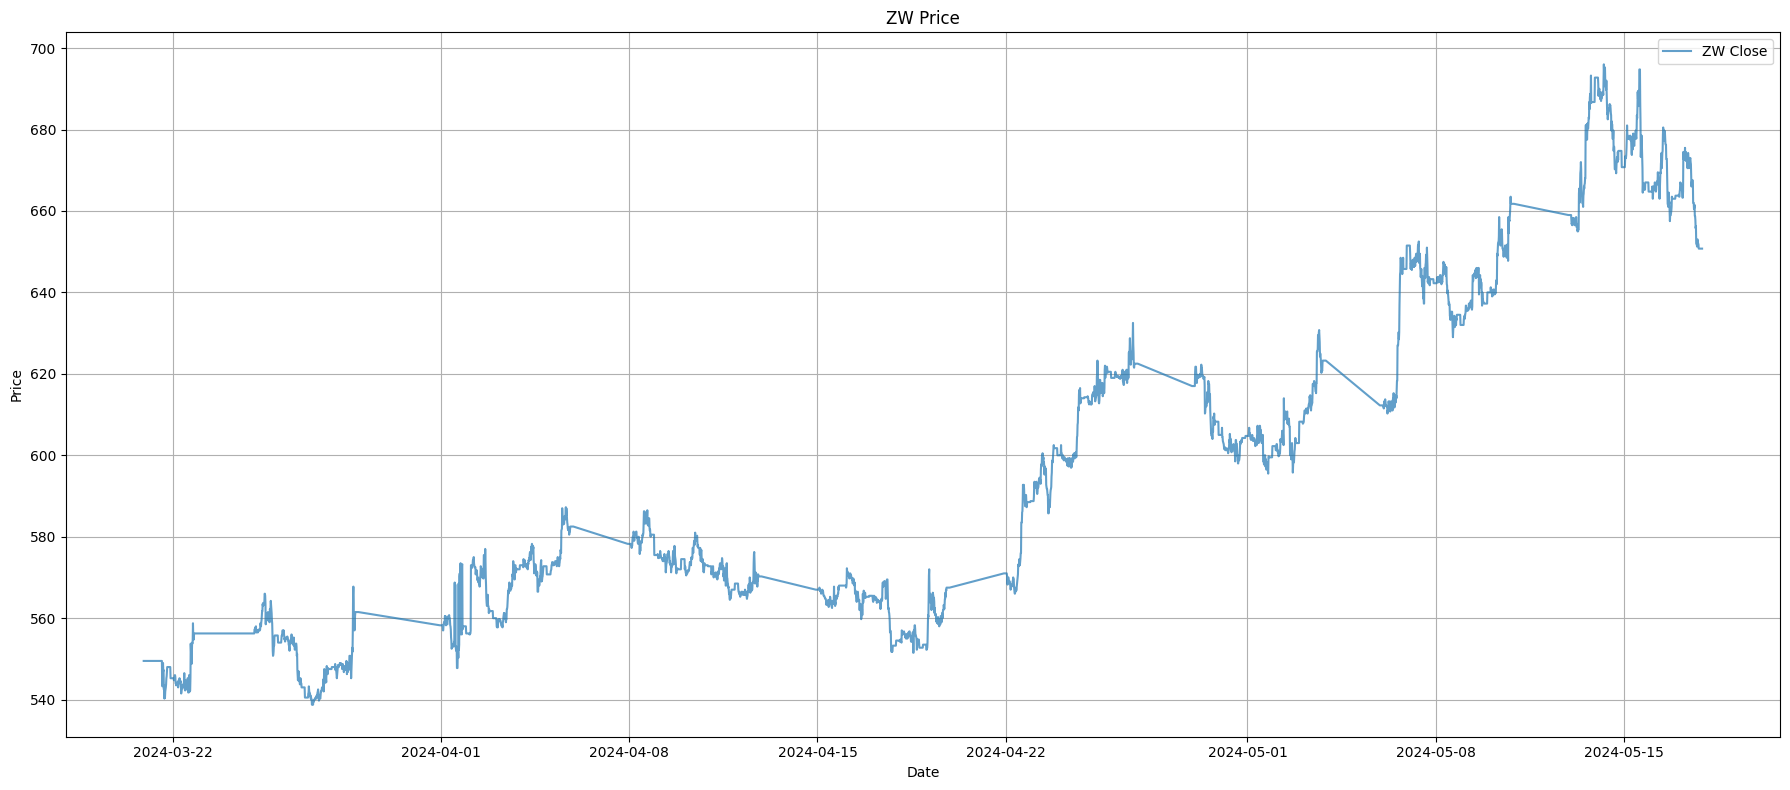

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Problem Defintion

Utilize meduim-frequency trade data for a set of 6 Future contracts listed on CME during a 250-day trading periods between 01/01/2023 and 01/01/2024. Future contracts are cross-sectional from metals, equities and volatiliyy. Trading is 23hours, with minute durations.

In [16]:
target_fut_df = futs_df[[f"{TARGET_FUT}_Close"]]

# SnR

In [17]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import multiprocessing

NUM_CORES = multiprocessing.cpu_count()

def find_optimal_clusters(data, max_clusters=150, min_clusters=2, max_no_improvement=5, sample_size=1000):
    def evaluate_clusters(n_clusters, data):
        km = MiniBatchKMeans(n_clusters=n_clusters, random_state=0, batch_size=(256 * NUM_CORES), max_no_improvement=max_no_improvement)
        labels = km.fit_predict(data)
        if len(np.unique(labels)) < 2:
            return -1
        score = silhouette_score(data, labels, sample_size=sample_size)
        return score

    best_score = -1
    best_k = None
    low = min_clusters
    high = max_clusters

    while low <= high:
        mid = (low + high) // 2
        score = evaluate_clusters(mid, data)
        low_score = evaluate_clusters(mid - 1, data) if mid - 1 >= low else -1
        high_score = evaluate_clusters(mid + 1, data) if mid + 1 <= high else -1
        if score > best_score:
            best_score = score
            best_k = mid
        if low_score > score:
            high = mid - 1
        elif high_score > score:
            low = mid + 1
        else:
            break  # local maximum

    return best_k

def sr_clusters_dtw(df, cols, max_clusters=150):
    data = df[cols].values
    optimal_clusters = find_optimal_clusters(data, max_clusters=max_clusters)
    km_model = MiniBatchKMeans(n_clusters=optimal_clusters, batch_size=(256 * NUM_CORES))
    labels = km_model.fit_predict(data)

    cluster_df = pd.DataFrame(data, columns=cols)
    cluster_df['cluster'] = labels

    return cluster_df, km_model

def identify_support_resistance(cluster_df, km_model, target_col):
    centers = km_model.cluster_centers_
    cluster_means = cluster_df[['cluster', target_col]].groupby('cluster').mean()

    support_level = cluster_means.mean(axis=1).idxmin()
    support_value = centers[support_level].mean()

    resistance_level = cluster_means.mean(axis=1).idxmax()
    resistance_value = centers[resistance_level].mean()

    return support_value, resistance_value

# https://www.researchgate.net/publication/255993239_The_Bollinger_lines_and_pivot_points_-_methods_of_making_the_best_decision_in_the_stock_exchange
cols = [f"{TARGET_FUT}_High", f"{TARGET_FUT}_Low", f"{TARGET_FUT}_Open",
        f"{TARGET_FUT}_Close", f"{TARGET_FUT}_PP", f"{TARGET_FUT}_S1",
        f"{TARGET_FUT}_S2", f"{TARGET_FUT}_R1", f"{TARGET_FUT}_R2"]

futs_df[f"{TARGET_FUT}_PP"] = futs_df[[f"{TARGET_FUT}_High", f"{TARGET_FUT}_Low", f"{TARGET_FUT}_Close"]].mean(axis=1)
futs_df[f"{TARGET_FUT}_S1"] = 2 * futs_df[f"{TARGET_FUT}_PP"] - futs_df[f"{TARGET_FUT}_High"]
futs_df[f"{TARGET_FUT}_R1"] = 2 * futs_df[f"{TARGET_FUT}_PP"] - futs_df[f"{TARGET_FUT}_Low"]
futs_df[f"{TARGET_FUT}_S2"] = futs_df[f"{TARGET_FUT}_PP"] - (futs_df[f"{TARGET_FUT}_High"] - futs_df[f"{TARGET_FUT}_Low"])
futs_df[f"{TARGET_FUT}_R2"] = futs_df[f"{TARGET_FUT}_PP"] + (futs_df[f"{TARGET_FUT}_High"] - futs_df[f"{TARGET_FUT}_Low"])

cluster_df, km_model = sr_clusters_dtw(futs_df, cols)

cluster_centers = km_model.cluster_centers_
cluster_labels = np.unique(cluster_df['cluster'])
cluster_centers_df = pd.DataFrame(cluster_centers, index=cluster_labels, columns=cols)

support, resistance = identify_support_resistance(cluster_df, km_model, f"{TARGET_FUT}_Close")

print(f"Support Level: {support}")
print(f"Resistance Level: {resistance}")
cluster_centers_df

Support Level: 540.5466041489062
Resistance Level: 691.2532022057228


,ZW_High,ZW_Low,ZW_Open,ZW_Close,ZW_PP,ZW_S1,ZW_S2,ZW_R1,ZW_R2
0,570.284377,568.222243,568.948689,569.335689,569.280770,568.277162,567.218636,570.339296,571.342904
1,643.885973,641.525763,642.601861,642.847646,642.753128,641.620282,640.392918,643.980492,645.113338
2,600.272142,598.330493,599.163216,599.380672,599.327769,598.383396,597.386120,600.325045,601.269417
3,675.734195,672.049242,673.483804,673.757315,673.846917,671.959639,670.161964,675.644592,677.531870
4,547.953103,546.300172,547.269397,547.071293,547.108190,546.263276,545.455259,547.916207,548.761121
5,620.136654,618.393181,619.250466,619.281500,619.270445,618.404235,617.526971,620.147709,621.013918
6,582.012689,579.833216,580.857684,580.768578,580.871495,579.730300,578.692022,581.909773,583.050967
7,561.550667,556.627398,560.090284,557.944954,558.707673,555.864679,553.784404,560.787948,563.630942
8,666.410332,664.206811,665.119941,665.343699,665.320281,664.230229,663.116760,666.433750,667.523802
9,693.551583,688.245018,689.739156,692.204279,691.333626,689.115670,686.027061,694.422235,696.640191


In [18]:
cluster_df.index = futs_df.index
cluster_df

,ZW_High,ZW_Low,ZW_Open,ZW_Close,ZW_PP,ZW_S1,ZW_S2,ZW_R1,ZW_R2,cluster
Date,,,,,,,,,,
2024-03-20 22:16:00+00:00,551.75,546.75,548.50,549.50,549.333333,546.916667,544.333333,551.916667,554.333333,27
2024-03-20 22:31:00+00:00,551.75,546.75,548.50,549.50,549.333333,546.916667,544.333333,551.916667,554.333333,27
2024-03-20 22:46:00+00:00,551.75,546.75,548.50,549.50,549.333333,546.916667,544.333333,551.916667,554.333333,27
2024-03-20 23:01:00+00:00,551.75,546.75,548.50,549.50,549.333333,546.916667,544.333333,551.916667,554.333333,27
2024-03-20 23:16:00+00:00,551.75,546.75,548.50,549.50,549.333333,546.916667,544.333333,551.916667,554.333333,27
...,...,...,...,...,...,...,...,...,...,...
2024-05-17 21:01:00+00:00,652.25,650.75,651.75,650.75,651.250000,650.250000,649.750000,651.750000,652.750000,11
2024-05-17 21:16:00+00:00,652.25,650.75,651.75,650.75,651.250000,650.250000,649.750000,651.750000,652.750000,11
2024-05-17 21:31:00+00:00,652.25,650.75,651.75,650.75,651.250000,650.250000,649.750000,651.750000,652.750000,11


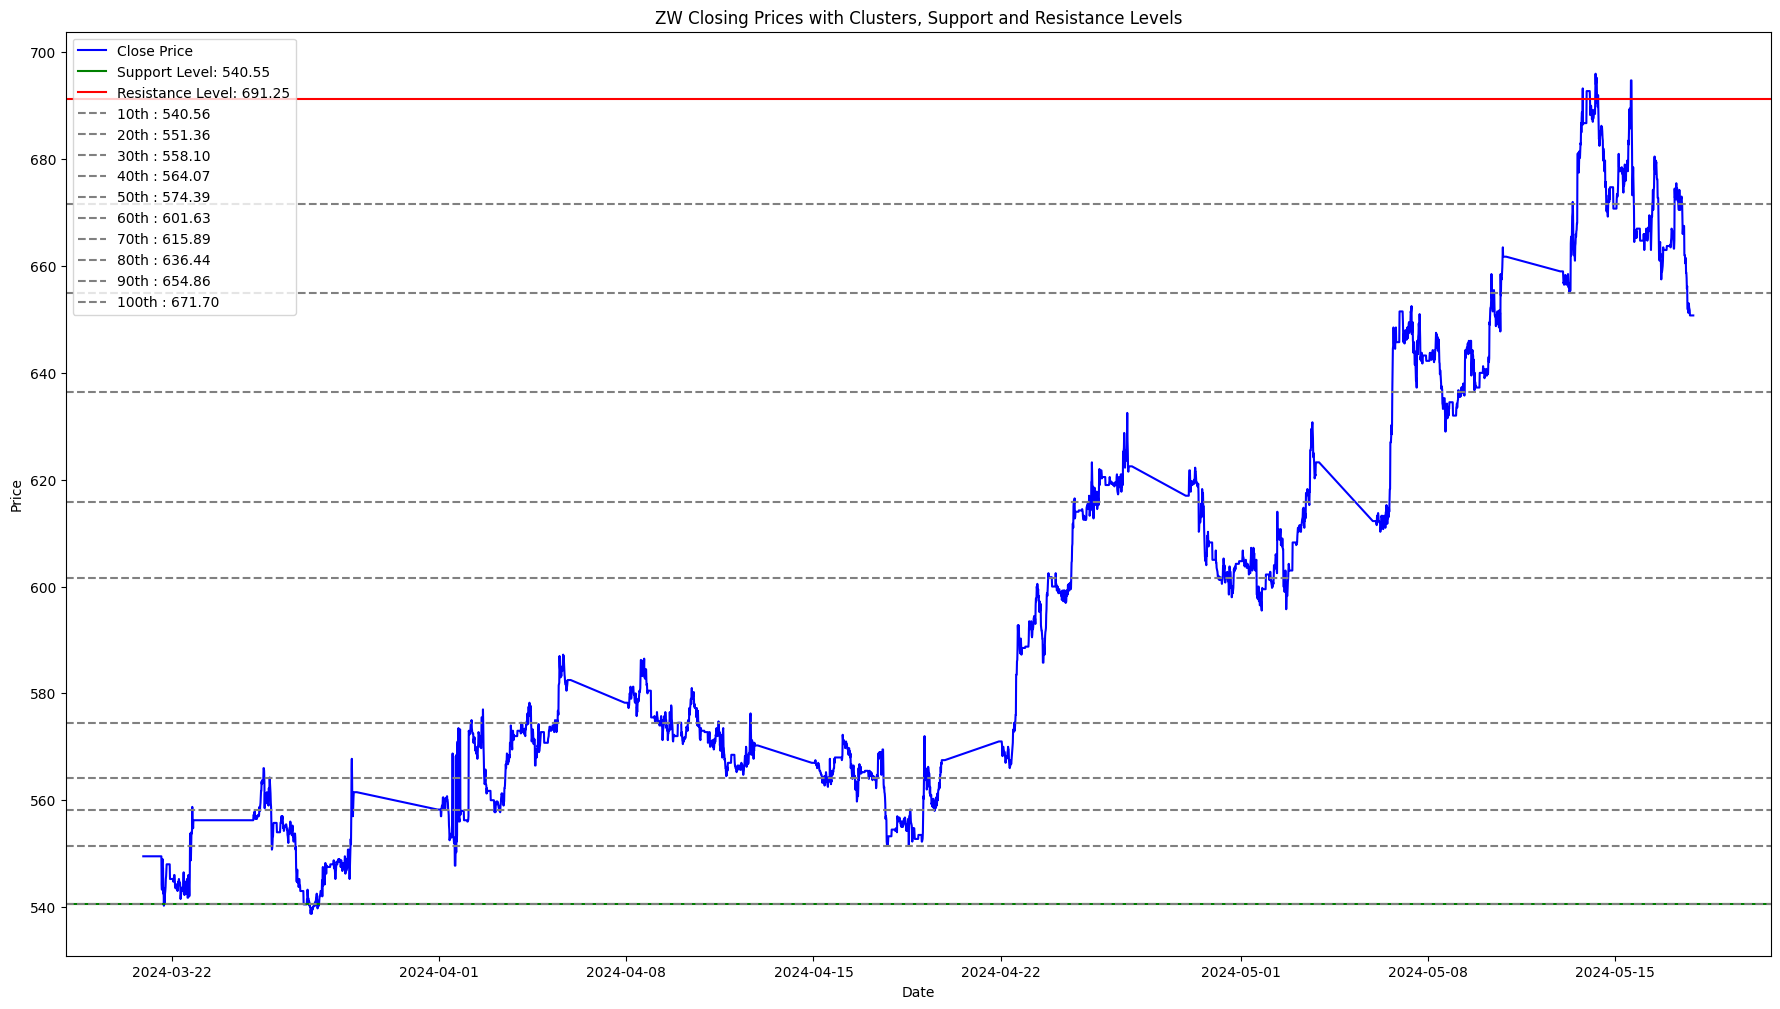

In [21]:
import matplotlib.pyplot as plt

deciles = cluster_centers_df[f"{TARGET_FUT}_Close"].quantile(np.arange(0.,1.,0.1))

# Plotting
plt.figure(figsize=(22, 12))
plt.plot(futs_df.index, futs_df[f"{TARGET_FUT}_Close"], label='Close Price', color='blue')

# Plot support and resistance levels
plt.axhline(y=support, color='green', linestyle='-', label=f'Support Level: {support:.2f}')
plt.axhline(y=resistance, color='red', linestyle='-', label=f'Resistance Level: {resistance:.2f}')

# Plot deciles
for decile, value in deciles.items():
    plt.axhline(y=value, linestyle='--', color='gray', label=f'{(decile+0.1)*100:.0f}th : {value:.2f}')


plt.title(f"{TARGET_FUT} Closing Prices with Clusters, Support and Resistance Levels")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Visual Results

# Test all Futs